In [53]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import v2
import random

In [54]:
class RotateWithKeypoints:
    def __init__(self, degrees=(-15, 15)):
        self.degrees = degrees  # tuple oder einzelwert

    def __call__(self, sample, angle_deg=None):
        img = sample["image"]
        kps = sample["keypoints"]
        _, H, W = img.shape

        # Winkel bestimmen
        if angle_deg is None:
            if isinstance(self.degrees, (tuple, list)):
                angle_deg = random.uniform(*self.degrees)
            else:
                angle_deg = float(self.degrees)

        # Bild rotieren
        rot = v2.RandomRotation(degrees=(angle_deg, angle_deg), expand=False)
        img_rot = rot(img)

        # Keypoints transformieren
        center = torch.tensor([W / 2, H / 2])
        x = kps[:, 1] * W
        y = kps[:, 0] * H

        valid = (kps != -1).all(dim=1)
        x_valid = x[valid]
        y_valid = y[valid]

        coords = torch.stack([x_valid, y_valid], dim=1)
        rel_coords = coords - center

        angle_rad = math.radians(-angle_deg)
        R = torch.tensor([
            [math.cos(angle_rad), -math.sin(angle_rad)],
            [math.sin(angle_rad),  math.cos(angle_rad)]
        ])
        rotated = rel_coords @ R.T + center

        x[valid] = rotated[:, 0]
        y[valid] = rotated[:, 1]

        # Zurück zu normierten Koordinaten
        x = x / W
        y = y / H
        kps_rot = torch.stack([y, x], dim=1)

        sample["image"] = img_rot
        sample["keypoints"] = kps_rot
        sample["angle"] = angle_deg  # optional für Debug

        return sample

In [65]:
class FLYDataset(Dataset):
    def __init__(self, path_to_data, mode="training", cam=0, transform=None):
        self.cam = cam
        self.H = 480
        self.W = 980
        self.transform = transform

        self.img_paths = []
        self.annotations = []

        if mode not in {"training", "test"}:
            raise ValueError("mode must be 'training' or 'test'")

        full_path = os.path.join(path_to_data, mode, f"cam{cam}")
        if not os.path.isdir(full_path):
            raise FileExistsError(f"Wrong path {full_path}")

        annotation_path = os.path.join(full_path, "annotations", "annotations.npz")
        image_path = os.path.join(full_path, "images")

        if not os.path.isfile(annotation_path):
            raise FileExistsError(f"Wrong annotation path {annotation_path}")
        if not os.path.isdir(image_path):
            raise FileExistsError(f"Wrong image path {image_path}")

        self.annotations = np.load(annotation_path)["points2d"]

        for image_name in sorted(os.listdir(image_path)):
            if image_name.endswith(".jpg"):
                self.img_paths.append(os.path.join(image_path, image_name))

        if len(self.img_paths) != len(self.annotations):
            raise IndexError("Number of images and annotations must be the same")

    def __getitem__(self, idx, transform=None):
        if idx >= len(self):
            raise LookupError("Invalid index")

        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img_tensor = torch.tensor(img, dtype=torch.float32) / 255.
        img_tensor = img_tensor.unsqueeze(0)  # [1, H, W]

        keypoints = torch.tensor(self.annotations[idx], dtype=torch.float32)  # [N, 2], (y,x) ∈ [0,1]

        # Vor-Filter (optional)
        pre_mask = (
            (keypoints[:, 0] > 0) & (keypoints[:, 0] < 1) &
            (keypoints[:, 1] > 0) & (keypoints[:, 1] < 1)
        )
        keypoints[~pre_mask] = -1.0

        sample = {
            "image": img_tensor,
            "keypoints": keypoints
        }

        transform_to_use = transform or self.transform
        if transform_to_use:
            sample = transform_to_use(sample)

        # Nach-Filter: Maskiere alles was out-of-bounds ist
        kps = sample["keypoints"]
        mask = (
            (kps[:, 0] >= 0) & (kps[:, 0] <= 1) &
            (kps[:, 1] >= 0) & (kps[:, 1] <= 1)
        )
        kps[~mask] = -1.0
        sample["keypoints"] = kps

        return sample["image"], sample["keypoints"]

    
    def __len__(self):
        # returning whole length of the dataset / number of images
        return len(self.img_paths)
    
    def __getvisual__(self, idx=0, transform=None):
        """
        Gibt das Bild und die gültigen Keypoints in Pixelkoordinaten zurück.
        Optional: wendet eine andere Transform an als im Dataset.
        Kein Plot!
        """
        # Hole das transformierte Sample (nutzt __getitem__)
        img, keypoints = self.__getitem__(idx, transform=transform)

        # Nur gültige Keypoints
        valid = (keypoints != -1).all(dim=-1)
        keypoints = keypoints[valid]

        # Normierte Koordinaten → Pixel
        x = keypoints[:, 1] * self.W  # x = Spalte
        y = keypoints[:, 0] * self.H  # y = Zeile

        return img.squeeze().numpy(), (x.numpy(), y.numpy())

In [66]:
transform = RotateWithKeypoints(degrees=(-20, 20))
dataset = FLYDataset("/scratch/cv-course2025/group2/data", transform=transform)

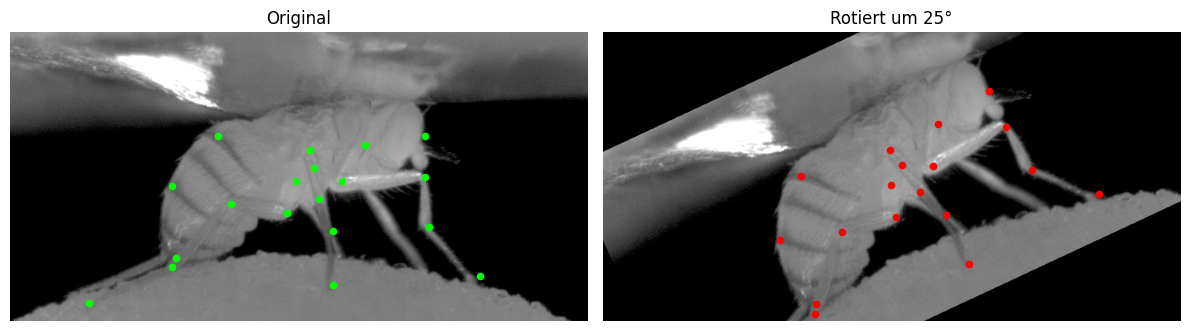

In [67]:
import matplotlib.pyplot as plt
from torchvision.transforms import v2

# --------- Parameter ----------
DATA_PATH = "/scratch/cv-course2025/group2/data"
IDX = 42
ROTATION_ANGLE = 25  # feste Gradzahl
# ------------------------------

# --------- Dataset laden ---------
dataset = FLYDataset(DATA_PATH, mode="training", cam=0)

# --------- Transform mit fixer Rotation vorbereiten ---------
rotate_transform = RotateWithKeypoints(degrees=(-30, 30))  # für Training zufällig

# Für Visualisierung: feste Gradzahl übergeben
def fixed_rotate(sample):
    return rotate_transform(sample, angle_deg=ROTATION_ANGLE)

# --------- Bild ohne Transform ---------
img1, (x1, y1) = dataset.__getvisual__(IDX)

# --------- Bild mit Rotation ---------
img2, (x2, y2) = dataset.__getvisual__(IDX, transform=fixed_rotate)

# --------- Visualisieren ---------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1, cmap="gray")
axes[0].scatter(x1, y1, c="lime", s=20)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(img2, cmap="gray")
axes[1].scatter(x2, y2, c="red", s=20)
axes[1].set_title(f"Rotiert um {ROTATION_ANGLE}°")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [8]:
class CNN_Fly(nn.Module):
    def __init__(self, input_size, embedding_size, num_joints=38):
        super().__init__()

        self.embedding_size = embedding_size
        self.num_joints = num_joints
        self.input_size = input_size  # expected: int or (H, W)

        """Encoder"""
        self.e1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.e2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.e3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.e4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.activation = nn.ReLU()

        """Bottleneck"""
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_size) if isinstance(input_size, tuple) else torch.zeros(1, 1, input_size, input_size)
            dummy_out = self.encoder(dummy)
            self.flatten_dim = dummy_out.view(1, -1).shape[1]
            
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.flatten_dim, 2 * embedding_size)

        """Decoder"""
        self.d1 = nn.Linear(embedding_size, self.flatten_dim)
        self.d2 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.d3 = nn.ConvTranspose2d(64, 64, 2, stride=2, output_padding=0)
        self.d4 = nn.ConvTranspose2d(64, 32, 2, stride=2, output_padding=0)
        self.d5 = nn.ConvTranspose2d(32, 1, 3, padding=1)
        self.last_activation = nn.Sigmoid()

        """Keypoint regression head"""
        self.kp_head = nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_joints * 2)
        )

    def encoder(self, x):
        x = self.activation(self.e1(x))
        x = self.activation(self.e2(x))
        x = self.activation(self.e3(x))
        x = self.activation(self.e4(x))
        return x

    def decode_image(self, z):
        x = self.d1(z)
        x = x.view(-1, 64, int(self.input_size[0] / 4), int(self.input_size[1] / 4))  # adjust based on encoder strides
        x = self.activation(self.d2(x))
        x = self.activation(self.d3(x))
        x = self.activation(self.d4(x))
        x = self.d5(x)
        return self.last_activation(x)


    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Encode
        enc = self.encoder(x)
        flat = self.flatten(enc)
        z_params = self.linear(flat)
        mu, logvar = torch.chunk(z_params, 2, dim=1)
        z = self.reparametrize(mu, logvar)
        kp_out = self.kp_head(z)
        #img_out = self.decode_image(z)

        return kp_out.view(-1, self.num_joints, 2), z, mu, logvar
        #return img_out, z, mu, logvar


In [9]:
trnsforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),                 # Flip image horizontally with 50% chance (also flips keypoints if used)
    v2.RandomRotation(degrees=15),                  # Rotate image randomly between -15 and +15 degrees
    #v2.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast by up to ±20% #TODO Clarify: does this make sense as a transform for the data?
    v2.ToDtype(torch.float32, scale=True),          # Convert image to float32 and rescale pixel values from [0,255] → [0,1]
    v2.Normalize(mean=(0.5,), std=(0.5,))           # Normalize image: (x - 0.5) / 0.5 → values now in [-1, 1]
])

In [12]:
trnsforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),                 # Flip image horizontally with 50% chance (also flips keypoints if used)
    v2.RandomRotation(degrees=15),                  # Rotate image randomly between -15 and +15 degrees
    #v2.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast by up to ±20% #TODO Clarify: does this make sense as a transform for the data?
    v2.ToDtype(torch.float32, scale=True),          # Convert image to float32 and rescale pixel values from [0,255] → [0,1]
    v2.Normalize(mean=(0.5,), std=(0.5,))           # Normalize image: (x - 0.5) / 0.5 → values now in [-1, 1]
])

# Train
def train_keypoint_model(model, dataset, num_epochs=10, batch_size=16, lr=1e-4, device="cuda"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for img, keypoints in loop:
            for i in range(img.size(0)):
                sample = {"image": img[i], "keypoints": keypoints[i]}
                sample = trnsforms(sample)  # apply v2 transforms

                img[i] = sample["image"]
                keypoints[i] = sample["keypoints"]

            img = img.to(device)           # [B, 1, H, W]
            keypoints = keypoints.to(device)     # [B, J, 2]

            preds, _, _, _ = model(img)       # [B, J, 2]
            keypoints_px = keypoints.clone()
            keypoints_px[:, 0] *= dataset.H  # x
            keypoints_px[:, 1] *= dataset.W  # y

            preds_px = preds.clone()
            preds_px[:, 1] *= dataset.W
            preds_px[:, 0] *= dataset.H
            loss = loss_fn(preds_px, keypoints_px)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Avg Loss: {total_loss / len(dataloader):.4f}")
    
    torch.save(model.state_dict(), os.path.join('.', f'fly-test.pt'))

    return model


# Visualize
def visualize_predictions(model, dataset, device="cuda", num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    loss_fn = torch.nn.MSELoss()
    losses = []

    for i in range(num_samples):
        img, true_kp = dataset[i]

        input_img = img.unsqueeze(0).to(device)  # [1, 1, H, W]

        with torch.no_grad():
            pred_kp, _, _, _ = model(input_img)
            
        pred_kp = pred_kp.squeeze(0).cpu()
        true_kp = true_kp.cpu()
        # Compute MSE loss on normalized coordinates
        # loss = loss_fn(pred_kp, true_kp).item()
        # losses.append(loss)

        # Convert normalized to pixel coordinates
        true_kp_px = true_kp.clone()
        true_kp_px[:, 0] *= dataset.H  # x
        true_kp_px[:, 1] *= dataset.W  # y

        pred_kp_px = pred_kp.clone()
        pred_kp_px[:, 1] *= dataset.W
        pred_kp_px[:, 0] *= dataset.H

        loss = loss_fn(pred_kp_px, true_kp_px).item()
        losses.append(loss)

        img_np = img.squeeze(0).numpy()

        ax = axes[i]
        ax.imshow(img_np, cmap="gray")
        ax.scatter(pred_kp_px[:, 1], pred_kp_px[:, 0], c="r", label="Pred", s=10)
        ax.scatter(true_kp_px[:, 1], true_kp_px[:, 0], c="g", label="GT", s=10, alpha=0.6)
        ax.set_title(f"Sample {i}\nMSE: {loss:.4f}")
        ax.axis("off")

    plt.tight_layout()
    plt.legend()
    plt.show()
    avg_loss = sum(losses) / len(losses)
    print(f"\nAverage MSE over {num_samples} samples: {avg_loss:.4f}")

model = CNN_Fly(input_size=(480, 960), embedding_size=32)
train_dataset = FLYDataset("/scratch/cv-course2025/group2/data")
test_dataset = FLYDataset("/scratch/cv-course2025/group2/data", mode="test")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use CPU for debug so you do not use too much GPU time

# m = train_keypoint_model(model, dataset, num_epochs=1)
#model.load_state_dict(torch.load("./fly-test.pt"))
#model.to(device)
# visualize_predictions(m, test_dataset, device=device)
